<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L36-LabelClassificationNode2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Label Prediction with Node2Vec

The importance and motivation behind Label Prediction with Node2Vec stem from its ability to generate more meaningful and effective node representations in graphs. Node2Vec is a graph embedding technique that allows capturing **structural and topological information in a graph**, making the generated node representations rich in information. By using these representations for Label Prediction, we can assign categories or labels to nodes more accurately. This is essential in applications where a detailed understanding of the graph's structure and semantics is required. It has significant implications in fields such as classifying users in social networks, assigning functions to nodes in transportation networks, or predicting gene functions in protein interaction networks, thus enhancing decision-making and efficiency in a wide range of applications.

Certainly, here are two examples of Label Predictions:

1. **Social Media User Classification:**
   In the context of social media networks, Label Prediction can be applied to classify users into different categories or labels based on their interests, behavior, or demographics. For instance, a social media platform might use Label Prediction to categorize users into groups such as "food enthusiasts," "travel enthusiasts," or "fitness enthusiasts." This information can be used to deliver more targeted content, advertisements, and recommendations to users, enhancing their experience on the platform.

2. **Disease Diagnosis Using Biological Networks:**
   In the field of bioinformatics, Label Prediction can be used to predict the disease status or phenotype of individuals based on their genetic or molecular profiles. For example, researchers may use Label Prediction in a protein-protein interaction network to identify which genes or proteins are associated with a specific disease or condition. This can aid in early disease diagnosis, the development of targeted therapies, and a deeper understanding of the molecular mechanisms underlying the disease.

3. Classification of Chemical Compounds in Antiviral Drug Discovery (ADIS Database):
    In the field of drug discovery, the ADIS (Antiviral Discovery Information System) database contains vast amounts of chemical compound data. Label Prediction can be employed to categorize these compounds into different classes or labels based on their potential antiviral activity. By training a model on known antiviral compounds and their properties, researchers can predict the antiviral potential of newly discovered compounds. This assists in the efficient screening of chemical libraries, saving time and resources in the search for effective antiviral drugs, especially critical in addressing emerging viral threats and pandemics.



## Formally:

Given an input graph $G$, and two nodes $u$ and $v$, predict the label of the edge between $u$ and $v$.

## Node2Vec for link prediction

We use the node embedding produced by Node2Vec, then we compute the edge embedding $(emb(E))$ as follow:

$$
emb(E) = emb(u,v) = \frac{1}{2}(Emb(u) + Emb(v))
$$

given the edge embedding we predict the binary label of the node using RandomForestClassifier


## step 1
Build a dataset different from cora :)  
  
We use AIDS[1][2] a dataset representing 2000 moleculas compounds, each
moleculas is represented as a graph and each graph has an attribute indicating if the compound is active or inactive against HIV.


<sub>[1] Riesen, K. and Bunke, H.: IAM Graph Database Repository for Graph Based Pattern Recognition and Machine Learning. In: da Vitora Lobo, N. et al. (Eds.), SSPR&SPR 2008, LNCS, vol. 5342, pp. 287-297, 2008.  
[2] AIDS Antiviral Screen Data (2004)

In [1]:
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install pyg_lib --no-index -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 47.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 54.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 69.1 MB/s eta 0:00:00


In [2]:
import torch
#!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from torch_geometric.datasets import TUDataset

import numpy as np

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = "cpu"
dataset = "AIDS"
data = TUDataset(".", name=dataset)

Processing...
Done!


### The dataset

In [5]:
print(data)
print(f"number of classes: {data.num_classes}\t\t(active),(inactive)")
print(f"number of features: {data.num_features}")
print(f"number of edge labels: {data.num_edge_labels}")

AIDS(2000)
number of classes: 2		(active),(inactive)
number of features: 38
number of edge labels: 3


In [6]:
data1 = data[1] # select second molecula

# extract edge list
edge_list = data1.edge_index.t().numpy()
print(edge_list[0:10])

[[0 1]
 [0 5]
 [1 0]
 [1 2]
 [1 6]
 [2 1]
 [2 3]
 [3 2]
 [3 4]
 [3 7]]


In [7]:
# extract edge attributes
edge_attr = data1.edge_attr.numpy()
print(edge_attr[0:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [8]:
import networkx as nx

# build the graph
graph1 = nx.Graph()

for i in range(len(edge_list)):
    u = edge_list[i][0]
    v = edge_list[i][1]
    graph1.add_edge(u,v,label=edge_attr[i])

print(graph1.edges(data=True))

[(np.int64(0), np.int64(1), {'label': array([1., 0., 0.], dtype=float32)}), (np.int64(0), np.int64(5), {'label': array([1., 0., 0.], dtype=float32)}), (np.int64(1), np.int64(2), {'label': array([1., 0., 0.], dtype=float32)}), (np.int64(1), np.int64(6), {'label': array([0., 1., 0.], dtype=float32)}), (np.int64(5), np.int64(4), {'label': array([1., 0., 0.], dtype=float32)}), (np.int64(5), np.int64(8), {'label': array([1., 0., 0.], dtype=float32)}), (np.int64(2), np.int64(3), {'label': array([1., 0., 0.], dtype=float32)}), (np.int64(3), np.int64(4), {'label': array([1., 0., 0.], dtype=float32)}), (np.int64(3), np.int64(7), {'label': array([0., 1., 0.], dtype=float32)}), (np.int64(4), np.int64(9), {'label': array([1., 0., 0.], dtype=float32)}), (np.int64(4), np.int64(10), {'label': array([1., 0., 0.], dtype=float32)})]


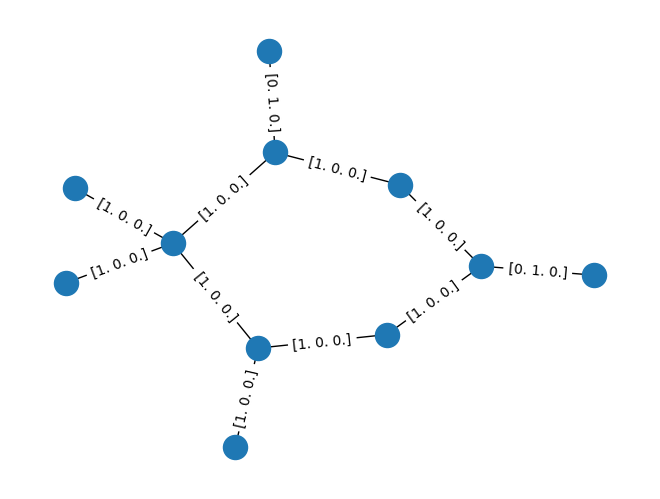

In [9]:
pos = nx.spring_layout(graph1)
nx.draw(graph1, pos)
nx.draw_networkx_edge_labels(graph1, pos, nx.get_edge_attributes(graph1, 'label'))
plt.show()

### Use only one moleculas compound

In [10]:
data.data

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[31385, 38], edge_index=[2, 64780], edge_attr=[64780, 3], y=[2000])

In [11]:
data = data[10]
data

Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])

In [12]:
# extract edge list
edge_list = data.edge_index.t().numpy()

In [13]:
# extract edge attributes
edge_attr = data.edge_attr.numpy()

In [14]:
# build the graph
graph2 = nx.Graph()

In [15]:
# Add edges to graph
for i in range(len(edge_list)):
    u = edge_list[i][0]
    v = edge_list[i][1]
    graph2.add_edge(u,v,label=edge_attr[i])

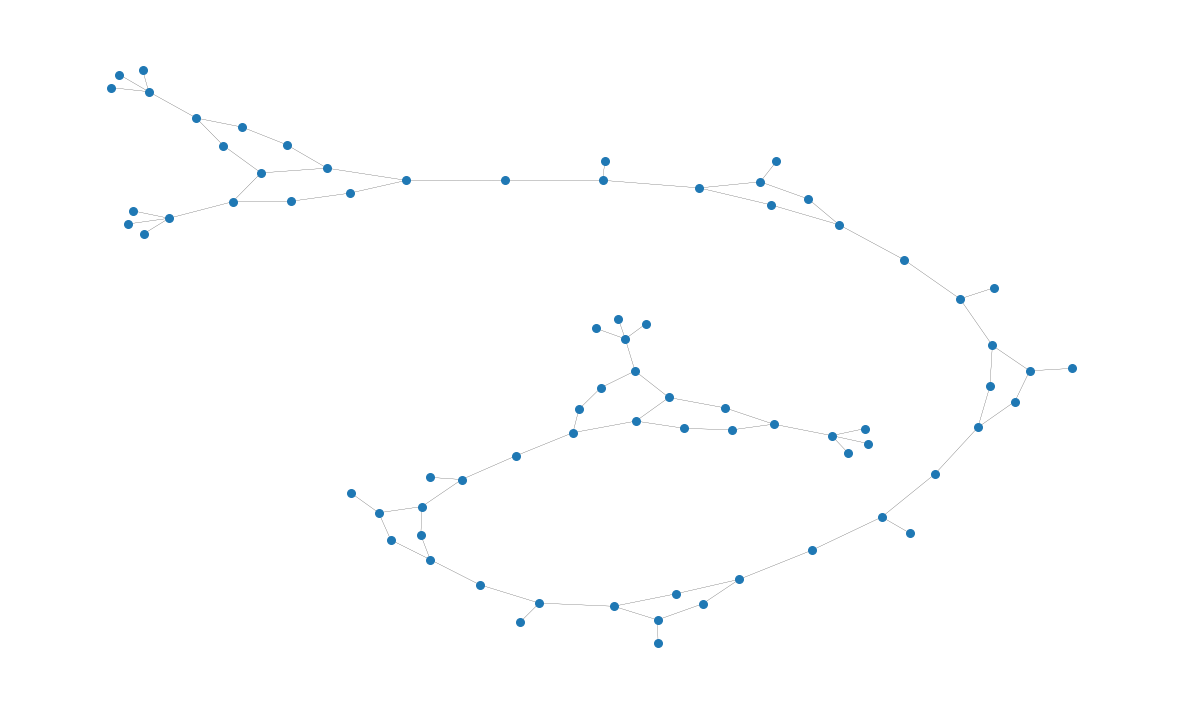

In [16]:
plot_options = {"node_size": 30, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(graph2, iterations=100, seed=1818)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(graph2, pos=pos, ax=ax, **plot_options)

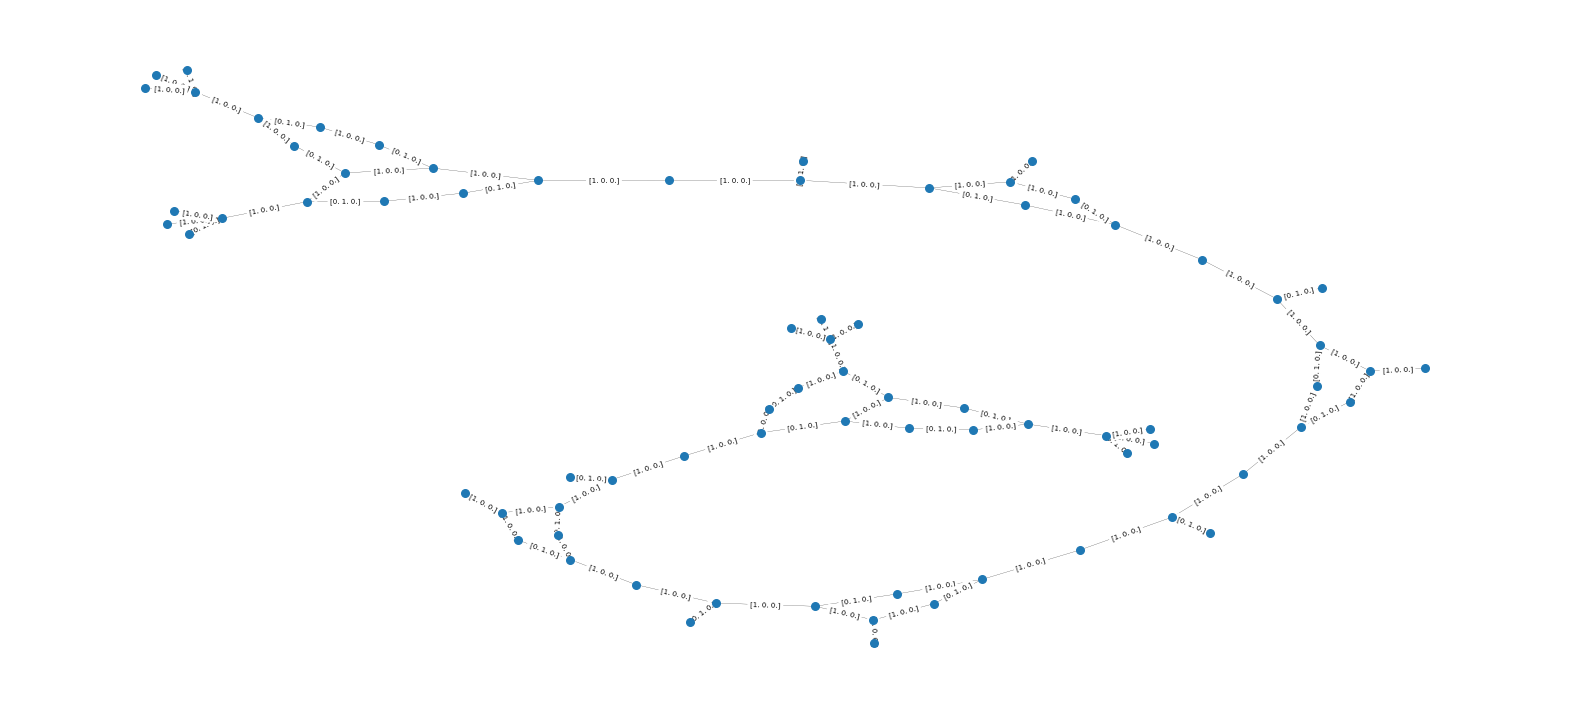

In [17]:
plot_options = {"node_size": 30, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(graph2, iterations=100, seed=1818)
fig, ax = plt.subplots(figsize=(20, 9))
ax.axis("off")
nx.draw(graph2, pos, ax=ax, **plot_options)
nx.draw_networkx_edge_labels(graph2, pos, nx.get_edge_attributes(graph2, 'label'), font_size=5)
plt.show()

### build the graph with
train_mask, test_mask, val_mask

In [18]:
np.random.seed(10)
# get the nodes
nodes = data.edge_index.t().numpy()
nodes = np.unique(list(nodes[:,0]) + list(nodes[:,1]))

np.random.shuffle(nodes) # shuffle node order
print(len(nodes))

76


In [19]:
# get train test and val sizes: (70% - 15% - 15%)
train_size = int(len(nodes)*0.7)
test_size = int(len(nodes)*0.85) - train_size
val_size = len(nodes) - train_size - test_size

In [20]:
# get train test and validation set of nodes
train_set = nodes[0:train_size]
test_set = nodes[train_size:train_size+test_size]
val_set = nodes[train_size+test_size:]


print(f'train lenght: {len(train_set)}, test lenght: {len(test_set)}, validation lenght: {len(val_set)}')
print(len(train_set)+len(test_set)+len(val_set) == len(nodes)) #check shuffle!

# print first 10 edges
print(f"train set\t{train_set[:10]}")
print(f"test set \t{test_set[:10]}")
print(f"val set  \t{val_set[:10]}")

train lenght: 53, test lenght: 11, validation lenght: 12
True
train set	[68 26 21  3 44 41  6 20  2 60]
test set 	[13 73 51 49 14 67 70 33 58 43]
val set  	[54 11 16 36 40  0  8 29 28 64]


In [21]:
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.

val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.

# first 15 nodes in mask
print(f"train mask \t{train_mask[0:15]}")
print(f"test mask  \t{test_mask[0:15]}")
print(f"val mask   \t{val_mask[0:15]}")

train mask 	tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
test mask  	tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
val mask   	tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')


In [22]:
# remove from the data what do we not use.

print(f"befor\t\t{data}")
data.x = None
data.edge_attr = None
data.y = None

befor		Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])


In [23]:
# add masks
data.train_mask = train_mask
data.test_mask = test_mask
data.val_mask = val_mask

print(f"after\t\t{data}")

after		Data(edge_index=[2, 166], train_mask=[76], test_mask=[76], val_mask=[76])


## step 2
Execute Node2Vec to get node embeddings

In [24]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [25]:
model

Node2Vec(76, 128)

In [26]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [27]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10)
    return acc


for epoch in range(1, 101):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')


Epoch: 10, Loss: 6.7704
Epoch: 20, Loss: 5.2338
Epoch: 30, Loss: 4.3675
Epoch: 40, Loss: 3.8234
Epoch: 50, Loss: 3.3880
Epoch: 60, Loss: 3.1146
Epoch: 70, Loss: 2.8321
Epoch: 80, Loss: 2.8242
Epoch: 90, Loss: 2.7368
Epoch: 100, Loss: 2.7225


In [28]:
z = model()

In [29]:
z # Tensor with each element of node, size embedding

Parameter containing:
tensor([[ 0.2717, -0.6972, -1.0702,  ..., -1.4286,  1.1341,  0.5215],
        [-1.1353, -0.6208, -0.5167,  ..., -1.1863, -1.0515, -0.0805],
        [ 0.4665,  0.0250, -0.6936,  ..., -0.5060, -1.0004, -0.2549],
        ...,
        [-0.8010,  0.3132, -0.3504,  ..., -0.0322, -0.6356,  0.7567],
        [ 1.4111, -1.5807,  1.4629,  ..., -1.1503, -0.0788,  2.0657],
        [ 0.7706,  0.9219, -0.4906,  ...,  0.1453,  2.4825, -1.1480]],
       device='cuda:0', requires_grad=True)

In [30]:
len(z) # number of nodes

76

In [31]:
len(z[0]) # embedding size

128

### visualize node embedding

In [32]:
# from tensor to numpy
node_2_vec = z.detach().cpu().numpy()

In [33]:
len(node_2_vec[0])

128

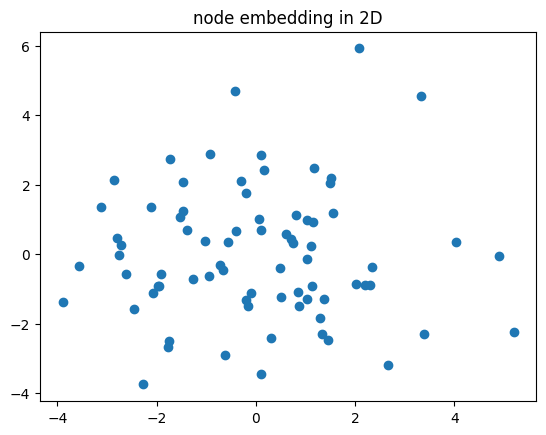

In [34]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
embedding_2D = pca.fit_transform(node_2_vec)


plt.title("node embedding in 2D")
plt.scatter(embedding_2D[:,0], embedding_2D[:,1])
plt.show()

## Step 3
Compute edge embedding

In [35]:
# reload AIDS dataset
# and pick the same graph


dataset = "AIDS"
data = TUDataset(".", name=dataset)
data = data[10]

In [36]:
data

Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])

In [37]:
# convert edge attributes from categorical to numerical
edge_attr_cat = data.edge_attr.numpy()
print(f"Categorical edge attributes:\n{edge_attr_cat[:10]}")

edge_attr = []
for i in edge_attr_cat:
    edge_attr.append(np.nonzero(i)[0][0])

print(f"\n\nNumerical edge attributes:\n{edge_attr[:10]}")

Categorical edge attributes:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


Numerical edge attributes:
[np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1)]


#### Visualize numerical edge attributes

In [38]:
graph3 = nx.Graph()

In [39]:
# Add edges to graph
for i in range(len(edge_list)):
    u = edge_list[i][0]
    v = edge_list[i][1]
    graph3.add_edge(u,v,label=edge_attr[i],color='r' if edge_attr[i]==1 else 'b')

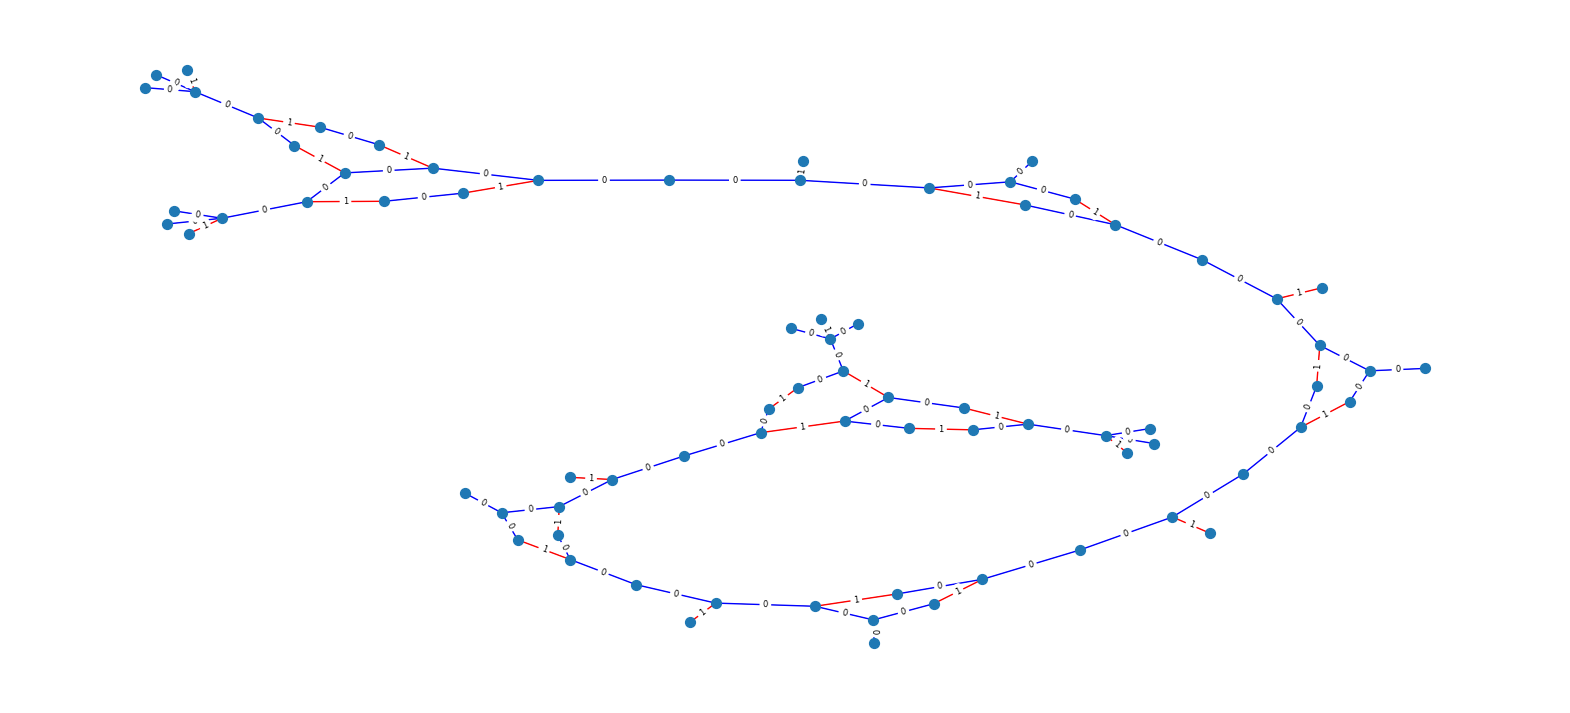

In [40]:
plot_options = {"node_size": 50, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(graph3, iterations=100, seed=1818)
fig, ax = plt.subplots(figsize=(20, 9))
ax.axis("off")
nx.draw(graph3, pos, ax=ax, **plot_options)

# plot color label in edge!
nx.draw_networkx_edges(
    graph3, pos,
    #edgelist=nx.get_edge_attributes(graph3, 'label').keys(),
    edge_color=[graph3[u][v]['color'] for u,v in graph3.edges()]
    )

nx.draw_networkx_edge_labels(graph3, pos, nx.get_edge_attributes(graph3, 'label'), font_size=6)
plt.show()

In [41]:
# compute edge embedding

edge_embedding = []
for u,v in data.edge_index.t():
    edge_embedding.append(np.mean([node_2_vec[u],node_2_vec[v]],0))
    # print(f'u: {u},v: {v} --> v: {node_2_vec[u]}, u:{node_2_vec[v]}')

### visualize edge embedding


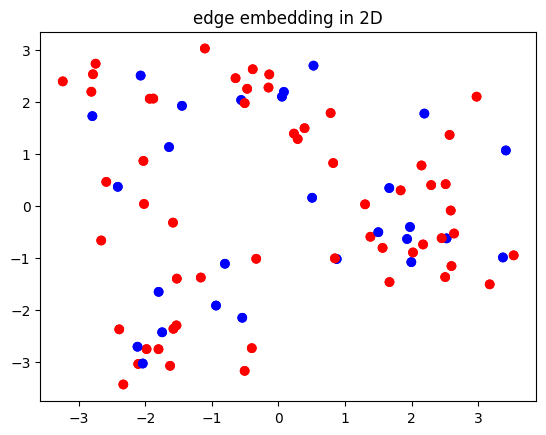

In [42]:
import pandas as pd
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(edge_embedding)



df = pd.DataFrame(dict(edge_att=edge_attr))
colors = {0:"red",1:"blue"}
plt.title("edge embedding in 2D")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1],c=df.edge_att.map(colors))
plt.show()

# not so good but we are using PCA to reduce the dim from 128 to 2

# Step 4
Use RandomForestClassifier with 10-fold cross validation

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [44]:
clf = RandomForestClassifier(max_depth=7,random_state=10)


scores = cross_val_score(estimator=clf, X=edge_embedding, y=edge_attr, cv=10)
np.mean(scores)

np.float64(0.6882352941176471)